# Variational Autoencoder 應用
用VAE來做手寫辨識，將最後的結果以動態呈現手寫數字例如 6 到 9 的變化

## 1. Initial

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

In [3]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


## 2. Load MNIST Dataset

In [4]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)

There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


In [5]:
# 調整資料長相及單位化
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

## Variational Autoencoder

Variational Autoencoder 的結構：

<img src="variational_autoencoder.png" alt="drawing" style="width: 800px;"/>

## 3. VAE 定義 Encoder 上的三個神經網路層

In [6]:
enc_1 = Dense(100, activation='sigmoid')
enc_mean = Dense(2)  # Mean
enc_log_var = Dense(2)  # Variance

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [7]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

定義抽樣函數 $X\sim N(0, 1)\Rightarrow \mu+\sigma X\sim N(\mu, \sigma^2)$ 和 $\sigma = e^{\frac{\log{\sigma^2}}{2}}$

In [8]:
# 定義抽樣函數
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
# 透過 Lambda 將其轉換成 Keras layer。
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [10]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [11]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

## 4. 建立 Loss 函數

In [12]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

## 5. 訓練 VAE

In [13]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [14]:
#VAE.fit(x_train, x_train, batch_size=32, epochs=5)  # Train By Joser
#VAE.save_weights('VAE_handwriting_model_weights_Joser.h5') # Save Weight
#VAE.load_weights('VAE_handwriting_model_weights_Joser.h5') # Load Weight

#VAE.fit(x_train, x_train, batch_size=32, epochs=100) 
VAE.load_weights('VAE_handwriting_model_weights.h5') # Load wught from 助教

## 6. VAE 分別定義出 Encoder 和 Decoder。

In [15]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [16]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


## 7.VAE  Encoder 的視覺化呈現

In [17]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 33950 圖的 latent 表示為 [[-2.3216045   0.51696885]]


In [18]:
indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

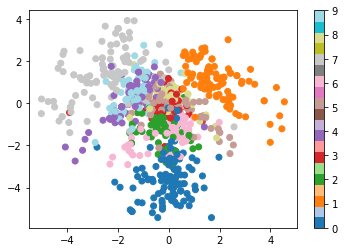

In [19]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

## 8.VAE Decoder 的視覺化呈現

In [20]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [21]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

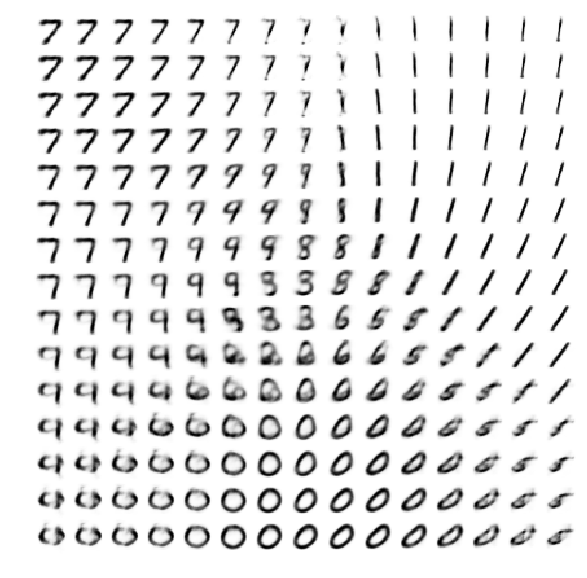

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

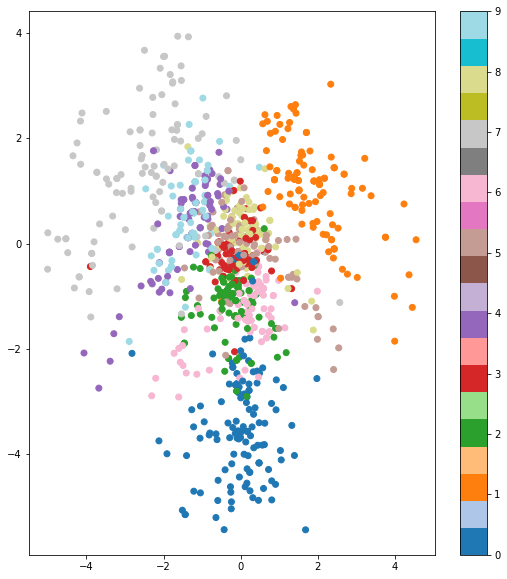

In [23]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()

## 9.VAE 隨機抽出手寫數字間的變化

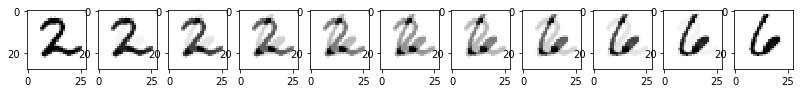

In [24]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

plt.figure(figsize=(15, 15))
data_0 = x_train0[idx_1]
ax2 = plt.subplot(2, 3, 1)
ax2.imshow(data_0, cmap='Greys')

sx =1

for t in np.arange(0, 1, 0.1):
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]
    ax3 = plt.subplot(2, 12, sx )
    ax3.imshow(data_t, cmap='Greys')
    sx = sx+1
ax4 = plt.subplot(2, 12, 11)
ax4.imshow(data_1, cmap='Greys')


## 10.VAE 動態呈現隨機抽出手寫數字間的變化

In [25]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [26]:
#idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
#data_0 = x_train0[idx_1]
#data_1 = x_train0[idx_2]


In [27]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>